In [211]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import random
try:
    from apex import amp, optimizers
    from apex.parallel import DistributedDataParallel as DDP
    from apex.fp16_utils import *
except ImportError:
    raise ImportError("Apex not installed")

In [216]:
n_gpu = 2

amp.initialize(enabled=True)

TypeError: initialize() missing 1 required positional argument: 'models'

In [165]:
class gaussNoise():
    """Adds gaussian noise to a tensor.

        >>> transforms.Compose([
        >>>     transforms.ToTensor(),
        >>>     gaussNoise(0.1, 0.05)),
        >>> ])

    """
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, tensor):
        noise = torch.zeros_like(tensor).normal_(self.mean, self.stddev)
        return tensor.add_(noise)

    def __repr__(self):
        repr = f"{self.__class__.__name__  }(mean={self.mean}, stddev={self.stddev})"
        return repr
#transforms.Compose([gaussNoise(0.1,0.05)])

In [174]:
transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(), # randomly flip and rotate
                                      #transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.ToTensor(),
                                      #transforms.RandomApply([gaussNoise(0.05,0.05)], p=0.5),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Import Datasets
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=4,
                         shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_test)
testloader = DataLoader(trainset, batch_size=4,
                         shuffle=True, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Define Classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified
cuda:0


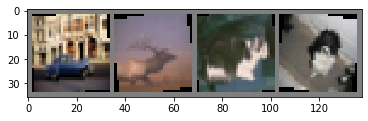

  car  deer   cat   dog


In [175]:
# Display some training images
def imshow(img):
    img = img / 2 + 0.5     #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

# Get some training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [176]:
# Define CNN Architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [214]:
# Initialize model
net = Net()
if n_gpu > 1:
    net = nn.DataParallel(net, list(range(n_gpu)))
# Send model to GPU
net = net.to(device)

# Initialize Loss Function    
criterion = nn.CrossEntropyLoss()
# Initialize SGD Optimizer
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9)
# Initialize Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9, last_epoch=-1)

# Define directory to save and load checkpoints
CHECKPOINT_DIR = './checkpoints/LeNet_augm/'
# Read in available checkpoints and sort 
checkpoints = sorted([f for f in os.listdir(CHECKPOINT_DIR) if os.path.isfile(CHECKPOINT_DIR + f)])
print(checkpoints)

## LOAD PREVIOUS CHECKPOINT ##
# If no checkpoints available
if len(checkpoints) == 0:
    print('Last Checkpoint: [None]')
    # Start from first epoch
    last_epoch = 0

# Else if checkpoints available
else:
    print('Loading Last Checkpoint:', checkpoints[-1])
    # Use last checkpoint number as last epoch
    last_epoch = int(checkpoints[-1][10:-3])
    # Load latest checkpoint
    latest_checkpoint = torch.load(CHECKPOINT_DIR + checkpoints[-1])
    
    # Load model state
    net.load_state_dict(latest_checkpoint['net_state'])
    net.train()
    # Load Optimizer and Scheduler State
    optimizer.load_state_dict(latest_checkpoint['optimizer_state'])
    scheduler.load_state_dict(latest_checkpoint['scheduler_state'])



print('Last Epoch:', last_epoch); print()
print('NETWORK MODEL:')
print(net); print()
print('MODEL STATE_DICT:')
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())
print()
print('OPTIMIZER STATE_DICT:')
for var_name in optimizer.state_dict():
    if var_name != 'state':
        print(var_name, "\t", optimizer.state_dict()[var_name])
print()
print('SCHEDULER STATE_DICT:')
for var_name in scheduler.state_dict():
    print(var_name, "\t", scheduler.state_dict()[var_name])
print('Learning Rate:', scheduler.get_lr())

['cifar_net_02.pt', 'cifar_net_04.pt', 'cifar_net_06.pt', 'cifar_net_08.pt', 'cifar_net_10.pt']
Loading Last Checkpoint: cifar_net_10.pt
Last Epoch: 10

NETWORK MODEL:
DataParallel(
  (module): Net(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=400, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
  )
)

MODEL STATE_DICT:
module.conv1.weight 	 torch.Size([6, 3, 5, 5])
module.conv1.bias 	 torch.Size([6])
module.conv2.weight 	 torch.Size([16, 6, 5, 5])
module.conv2.bias 	 torch.Size([16])
module.fc1.weight 	 torch.Size([120, 400])
module.fc1.bias 	 torch.Size([120])
module.fc2.weight 	 torch.Size([84, 120])
module.fc2.bias 	 torch.Size([84])
module.fc3.weight 	 torch.Size([10, 84])
module.fc3.b

In [215]:
# Train the Network
# Define Number of Epochs to train
n_epochs = 10
# Define noise factor 
noise_factor = 0.25

for epoch in range(last_epoch, last_epoch+n_epochs):
    print('EPOCH:', epoch+1, '   LR:', scheduler.get_lr())
    # Restart running loss and number of gaussian batches
    running_loss = 0.0
    gauss_batches = 0
    # For each batch
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data[0].to(device), data[1].to(device)
        inputs, labels = data[0], data[1]

        # Add noise
        prob_noise = random.random()
        if prob_noise >= 0.5:
            gauss_batches += 1
            ## add random noise to the input images
            inputs = inputs + noise_factor * torch.randn(*inputs.shape)
            # Clip the images to be between 0 and 1
            inputs = np.clip(inputs, 0., 1.)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        #with amp_handle.scale_loss(loss, optimizer) as scaled_loss:
        #    scaled_loss.backward()
        loss.backward()
        optimizer.step()

        # Print Statistics
        running_loss += loss.item()
        if i % 1000 == 999:
            print('[%d, %5d] loss: %.3f, Noise batches %d / 1000' %
                  (epoch + 1, i + 1, running_loss / 1000, gauss_batches))
            running_loss = 0.0
            gauss_batches = 0
    
    # Step Learning Rate Scheduler
    scheduler.step()
    
    # Save checkpoint every 5 epochs
    if (epoch+1) % 2 == 0:
        PATH = CHECKPOINT_DIR+'cifar_net_' + str(epoch+1) + '.pt'
        current_state = {'net_state': net.state_dict(),
                         'optimizer_state': optimizer.state_dict(),
                         'scheduler_state': scheduler.state_dict()}
        torch.save(current_state, PATH)
        print('Checkpoint for Epoch', epoch+1, 'saved in', PATH)
    
print('Finished Training')

EPOCH: 11    LR: [0.0020950118882812497]


RuntimeError: The old Amp API is no longer supported.  Please move to the new API, documented here:  https://nvidia.github.io/apex/amp.html.  Transition guide:  https://nvidia.github.io/apex/amp.html#transition-guide-for-old-api-users

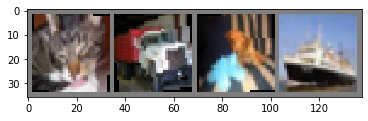

GroundTruth:   cat truck   dog  ship
Predicted:    cat  bird   cat  ship


In [204]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# Print Images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

net = Net()
if n_gpu > 1:
    net = nn.DataParallel(net, list(range(n_gpu)))

# Load latest checkpoint
latest_checkpoint = torch.load(PATH)
    
# Load model state
net.load_state_dict(latest_checkpoint['net_state'])
net.eval()
net.to(device)

images = images.to(device)
labels = labels.to(device)
outputs = net(images)

_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [205]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 51 %


In [199]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 51 %
Accuracy of   car : 51 %
Accuracy of  bird : 23 %
Accuracy of   cat : 43 %
Accuracy of  deer : 40 %
Accuracy of   dog : 25 %
Accuracy of  frog : 52 %
Accuracy of horse : 60 %
Accuracy of  ship : 68 %
Accuracy of truck : 68 %
